In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries - PyTorch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.models import resnet101, resnet50, resnet18
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100 
from torchvision import datasets, models, transforms
from torchinfo import summary

from tqdm import tqdm

In [2]:
torch.manual_seed(0)

In [3]:
torch.cuda.manual_seed(0)

In [ ]:
!rm -rf /kaggle/working/*

In [ ]:
!rm -rf /kaggle/working/models/*

In [4]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [5]:
os.makedirs("/kaggle/working/aftermodels",exist_ok=True)

# Compute stats

In [ ]:
stat_train_data = CIFAR100(download=True, root="./data", transform=tt.ToTensor())
stat_test_data = CIFAR100(root="./data", train=False, transform=tt.ToTensor())

In [ ]:
imgs_train = torch.stack([img_t for img_t ,_ in stat_train_data],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in stat_test_data],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

# Stat and transform

In [6]:
stats=((0.50736207, 0.4866896, 0.44108862), (0.26748815, 0.2565931, 0.2763085))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# 100 classes

In [7]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

100%|██████████| 169001437/169001437 [00:02<00:00, 58185939.75it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [8]:
batch_size=128
num_work=4
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

# 20 classes

In [9]:
class CIFAR100Coarse(torch.utils.data.Dataset):
    def __init__(self, cifar100_dataset) ->None:
        self.cifar100_dataset = cifar100_dataset
        
        # Define the mapping from fine labels to coarse labels
        self.fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
        
        # Mapping from superclass labels to superclass names
        self.coarse_label_names = {
            0: 'aquatic mammals',
            1: 'fish',
            2: 'flowers',
            3: 'food containers',
            4: 'fruit and vegetables',
            5: 'household electrical devices',
            6: 'household furniture',
            7: 'insects',
            8: 'large carnivores',
            9: 'large man-made outdoor things',
            10: 'large natural outdoor scenes',
            11: 'large omnivores and herbivores',
            12: 'medium-sized mammals',
            13: 'non-insect invertebrates',
            14: 'people',
            15: 'reptiles',
            16: 'small mammals',
            17: 'trees',
            18: 'vehicles 1',
            19: 'vehicles 2'
        }

    def __getitem__(self, index):
        img, target = self.cifar100_dataset[index]

        # Convert fine label to coarse label
        target_coarse = self.fine_to_coarse[target]

        return img, target, target_coarse

    def __len__(self):
        return len(self.cifar100_dataset)

    def get_coarse_label_name(self, label):
        return self.coarse_label_names[label]

    def get_all_coarse_label_names(self):
        return self.coarse_label_names.values()


In [10]:
train_data_20=CIFAR100Coarse(train_data)
test_data_20=CIFAR100Coarse(test_data)

In [11]:
batch_size=128
num_work=4
train_dl_20 = DataLoader(train_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl_20 = DataLoader(test_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

## Print number of items for each superclass

In [ ]:
train_classes_20={}

for img,label in train_data_20:
    class_name=train_data_20.coarse_label_names[label]
    if class_name not in train_classes_20:
        train_classes_20[class_name]=1
    else:
        train_classes_20[class_name]+=1

In [ ]:
train_classes_20

# Device - GPU cuda

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [13]:
class DoubleResNet18(nn.Module):
    def __init__(self, leaf_classes=100, superclasses=20):
        super(DoubleResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.resnet.maxpool=nn.Identity()
        num_ftrs = self.resnet.fc.in_features #512 ;)
        self.fc1 = nn.Linear(num_ftrs, leaf_classes)
        self.fc2 = nn.Linear(num_ftrs, superclasses)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1) # to sprawdzić czy potrzeba!!!!!
        
        logits1 = self.fc1(x) # to będzie na 100 class oczywiście
        
        logits2 = self.fc2(x) #superklasy
        
        return logits1, logits2

In [14]:
model=DoubleResNet18()

In [15]:
model=model.to(device)

In [ ]:
summary(model,(128,3,32,32))

# Optimizer, scheduler, criterion

In [16]:
# For optimizer:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4
criterion_I = nn.CrossEntropyLoss()
criterion_II = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,80,120,140], gamma=0.2)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True,factor=0.1)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

# Training and validation loop

In [18]:
num_epochs=300

In [19]:
os.makedirs('/kaggle/working/models/')

FileExistsError: [Errno 17] File exists: '/kaggle/working/models/'

In [ ]:
!rm -rf /kaggle/working/models/*

# Train for 20 classes

In [20]:
train_loss=[]
train_loss_I=[]
train_loss_II=[]
train_acc=[]
train_acc_coarse=[]
test_loss=[]
test_loss_I=[]
test_loss_II=[]
test_acc=[]
test_acc_coarse=[]
alpha=0.9
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    correct_predictions_coarse=0
    total_samples = 0
    total_samples_coarse=0
    total_loss_I=0.0
    total_loss_II=0.0

    data_loader = tqdm(train_dl_20, total=len(train_dl_20), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets, targets_coarse) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)


        logits1, logits2 = model(inputs)
        loss_I = criterion_I(logits1, targets)
        loss_II=criterion_II(logits2, targets_coarse)
        loss=(alpha)*loss_I+(1-alpha)*loss_II
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_I += loss_I.item()
        total_loss_II += loss_II.item()

        _, predicted = logits1.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        _, predicted_coarse = logits2.max(1)
        correct_predictions_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_samples_coarse += targets_coarse.size(0)

        # Progress bar description
        data_loader.set_postfix(Loss=total_loss / (batch_idx + 1),Loss_I=total_loss_I/(batch_idx + 1), Loss_II=total_loss_II/(batch_idx + 1),
                                Accuracy=correct_predictions / total_samples, Accuracy_coarse=correct_predictions_coarse/total_samples_coarse)

    average_loss = total_loss / len(train_dl_20)
    avg_loss_I=total_loss_I/len(train_dl_20)
    avg_loss_II=total_loss_II/len(train_dl_20)
    Accuracy=correct_predictions / total_samples
    Accuracy_coarse=correct_predictions_coarse/total_samples_coarse
    
    train_loss.append(average_loss)
    train_loss_I.append(avg_loss_I)
    train_loss_II.append(avg_loss_II)
    train_acc.append(Accuracy)
    train_acc_coarse.append(Accuracy_coarse)

    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    correct_test_coarse, total_test_coarse = 0, 0
    total_loss_test_I, total_loss_test_II= 0, 0
    with torch.no_grad():
        for (inputs, targets,targets_coarse) in test_dl_20:
            inputs, targets,targets_coarse  = inputs.to(device), targets.to(device), targets_coarse.to(device)
            logits1, logits2  = model(inputs)
            loss_I = criterion_I(logits1, targets)
            loss_II=criterion_II(logits2, targets_coarse)
            loss=(alpha)*loss_I+(1-alpha)*loss_II
            total_loss_test += loss.item()
            total_loss_test_I += loss_I.item()
            total_loss_test_II += loss_II.item()

            __, predicted = logits1.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)
            
            _, predicted_coarse = logits2.max(1)
            correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
            total_test_coarse += targets_coarse.size(0)

        accuracy_test = correct_test / total_test
        accuracy_test_coarse=correct_test_coarse/total_test_coarse
        average_loss_test = total_loss_test / len(test_dl_20)
        avg_loss_test_I=total_loss_test_I/len(test_dl_20)
        avg_loss_test_II=total_loss_test_II/len(test_dl_20)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Loss_I: {avg_loss_I:.4f}, Loss_II: {avg_loss_II:.4f}, Accuracy: {Accuracy * 100:.2f}%, Accuracy coarse: {Accuracy_coarse * 100:.2f}%,\
    Loss test: {average_loss_test:.4f},Loss_I test: {avg_loss_test_I:.4f},Loss_II test: {avg_loss_test_II:.4f} Accuracy test: {100 * accuracy_test:.2f}%, Accuracy test coarse: {100 * accuracy_test_coarse:.2f}%')
    
    test_loss.append(average_loss_test)
    test_loss_I.append(avg_loss_test_I)
    test_loss_II.append(avg_loss_test_II)
    test_acc.append(accuracy_test)
    test_acc_coarse.append(accuracy_test_coarse)

    model_save_path = '/kaggle/working/models/cifar100_20classes_ep' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': Accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
    
#     if epoch%5==0:
#         model_save_path = '/kaggle/working/models/resnet_cifar10_' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    scheduler.step(average_loss_test)
    torch.save(training_stats, model_save_path)

Epoch [1/300]: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s, Accuracy=0.123, Accuracy_coarse=0.244, Loss=3.64, Loss_I=3.78, Loss_II=2.43] 


Epoch [1/300] - Loss: 3.6417, Loss_I: 3.7763, Loss_II: 2.4304, Accuracy: 12.33%, Accuracy coarse: 24.40%,    Loss test: 3.1428,Loss_I test: 3.2558,Loss_II test: 2.1256 Accuracy test: 20.68%, Accuracy test coarse: 34.17%


Epoch [2/300]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, Accuracy=0.252, Accuracy_coarse=0.393, Loss=2.87, Loss_I=2.98, Loss_II=1.94]


Epoch [2/300] - Loss: 2.8731, Loss_I: 2.9762, Loss_II: 1.9446, Accuracy: 25.16%, Accuracy coarse: 39.27%,    Loss test: 2.5018,Loss_I test: 2.5909,Loss_II test: 1.7001 Accuracy test: 32.35%, Accuracy test coarse: 45.65%


Epoch [3/300]: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s, Accuracy=0.354, Accuracy_coarse=0.487, Loss=2.36, Loss_I=2.44, Loss_II=1.61]


Epoch [3/300] - Loss: 2.3576, Loss_I: 2.4402, Loss_II: 1.6141, Accuracy: 35.39%, Accuracy coarse: 48.72%,    Loss test: 2.0680,Loss_I test: 2.1378,Loss_II test: 1.4399 Accuracy test: 42.19%, Accuracy test coarse: 53.85%


Epoch [4/300]: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s, Accuracy=0.434, Accuracy_coarse=0.556, Loss=2, Loss_I=2.07, Loss_II=1.39]   


Epoch [4/300] - Loss: 2.0041, Loss_I: 2.0722, Loss_II: 1.3915, Accuracy: 43.44%, Accuracy coarse: 55.64%,    Loss test: 1.8364,Loss_I test: 1.8990,Loss_II test: 1.2734 Accuracy test: 48.15%, Accuracy test coarse: 58.76%


Epoch [5/300]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, Accuracy=0.489, Accuracy_coarse=0.597, Loss=1.77, Loss_I=1.83, Loss_II=1.25]


Epoch [5/300] - Loss: 1.7730, Loss_I: 1.8314, Loss_II: 1.2469, Accuracy: 48.89%, Accuracy coarse: 59.66%,    Loss test: 1.6893,Loss_I test: 1.7456,Loss_II test: 1.1822 Accuracy test: 50.89%, Accuracy test coarse: 62.30%


Epoch [6/300]: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s, Accuracy=0.531, Accuracy_coarse=0.636, Loss=1.61, Loss_I=1.66, Loss_II=1.13]


Epoch [6/300] - Loss: 1.6077, Loss_I: 1.6604, Loss_II: 1.1338, Accuracy: 53.11%, Accuracy coarse: 63.61%,    Loss test: 1.5394,Loss_I test: 1.5892,Loss_II test: 1.0907 Accuracy test: 55.41%, Accuracy test coarse: 64.66%


Epoch [7/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.564, Accuracy_coarse=0.661, Loss=1.48, Loss_I=1.53, Loss_II=1.05]


Epoch [7/300] - Loss: 1.4847, Loss_I: 1.5328, Loss_II: 1.0523, Accuracy: 56.37%, Accuracy coarse: 66.10%,    Loss test: 1.4977,Loss_I test: 1.5501,Loss_II test: 1.0263 Accuracy test: 56.14%, Accuracy test coarse: 66.83%


Epoch [8/300]: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s, Accuracy=0.591, Accuracy_coarse=0.685, Loss=1.38, Loss_I=1.42, Loss_II=0.983]


Epoch [8/300] - Loss: 1.3801, Loss_I: 1.4243, Loss_II: 0.9825, Accuracy: 59.11%, Accuracy coarse: 68.55%,    Loss test: 1.3858,Loss_I test: 1.4322,Loss_II test: 0.9680 Accuracy test: 58.56%, Accuracy test coarse: 68.24%


Epoch [9/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.615, Accuracy_coarse=0.703, Loss=1.29, Loss_I=1.33, Loss_II=0.925]


Epoch [9/300] - Loss: 1.2917, Loss_I: 1.3325, Loss_II: 0.9246, Accuracy: 61.51%, Accuracy coarse: 70.26%,    Loss test: 1.3670,Loss_I test: 1.4132,Loss_II test: 0.9507 Accuracy test: 59.37%, Accuracy test coarse: 69.31%


Epoch [10/300]: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s, Accuracy=0.635, Accuracy_coarse=0.722, Loss=1.22, Loss_I=1.25, Loss_II=0.873]


Epoch [10/300] - Loss: 1.2168, Loss_I: 1.2550, Loss_II: 0.8730, Accuracy: 63.50%, Accuracy coarse: 72.18%,    Loss test: 1.3207,Loss_I test: 1.3654,Loss_II test: 0.9182 Accuracy test: 60.75%, Accuracy test coarse: 70.46%


Epoch [11/300]: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s, Accuracy=0.651, Accuracy_coarse=0.736, Loss=1.16, Loss_I=1.19, Loss_II=0.828]


Epoch [11/300] - Loss: 1.1562, Loss_I: 1.1926, Loss_II: 0.8283, Accuracy: 65.07%, Accuracy coarse: 73.58%,    Loss test: 1.3294,Loss_I test: 1.3779,Loss_II test: 0.8927 Accuracy test: 60.61%, Accuracy test coarse: 71.00%


Epoch [12/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.665, Accuracy_coarse=0.746, Loss=1.11, Loss_I=1.15, Loss_II=0.796]


Epoch [12/300] - Loss: 1.1113, Loss_I: 1.1463, Loss_II: 0.7959, Accuracy: 66.47%, Accuracy coarse: 74.62%,    Loss test: 1.2866,Loss_I test: 1.3331,Loss_II test: 0.8683 Accuracy test: 62.30%, Accuracy test coarse: 72.39%


Epoch [13/300]: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s, Accuracy=0.672, Accuracy_coarse=0.755, Loss=1.07, Loss_I=1.11, Loss_II=0.771]


Epoch [13/300] - Loss: 1.0736, Loss_I: 1.1072, Loss_II: 0.7709, Accuracy: 67.23%, Accuracy coarse: 75.48%,    Loss test: 1.2795,Loss_I test: 1.3256,Loss_II test: 0.8646 Accuracy test: 62.78%, Accuracy test coarse: 72.28%


Epoch [14/300]: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s, Accuracy=0.686, Accuracy_coarse=0.763, Loss=1.04, Loss_I=1.07, Loss_II=0.747] 


Epoch [14/300] - Loss: 1.0360, Loss_I: 1.0681, Loss_II: 0.7474, Accuracy: 68.58%, Accuracy coarse: 76.33%,    Loss test: 1.2408,Loss_I test: 1.2858,Loss_II test: 0.8361 Accuracy test: 63.05%, Accuracy test coarse: 73.13%


Epoch [15/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.697, Accuracy_coarse=0.77, Loss=0.997, Loss_I=1.03, Loss_II=0.72]   


Epoch [15/300] - Loss: 0.9970, Loss_I: 1.0278, Loss_II: 0.7197, Accuracy: 69.70%, Accuracy coarse: 77.03%,    Loss test: 1.2414,Loss_I test: 1.2872,Loss_II test: 0.8297 Accuracy test: 63.44%, Accuracy test coarse: 73.56%


Epoch [16/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.702, Accuracy_coarse=0.779, Loss=0.969, Loss_I=0.999, Loss_II=0.698]


Epoch [16/300] - Loss: 0.9688, Loss_I: 0.9989, Loss_II: 0.6980, Accuracy: 70.17%, Accuracy coarse: 77.92%,    Loss test: 1.2197,Loss_I test: 1.2631,Loss_II test: 0.8298 Accuracy test: 64.19%, Accuracy test coarse: 73.33%


Epoch [17/300]: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s, Accuracy=0.712, Accuracy_coarse=0.783, Loss=0.938, Loss_I=0.966, Loss_II=0.682]


Epoch [17/300] - Loss: 0.9378, Loss_I: 0.9663, Loss_II: 0.6816, Accuracy: 71.21%, Accuracy coarse: 78.28%,    Loss test: 1.2104,Loss_I test: 1.2559,Loss_II test: 0.8015 Accuracy test: 64.71%, Accuracy test coarse: 74.39%


Epoch [18/300]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, Accuracy=0.717, Accuracy_coarse=0.789, Loss=0.921, Loss_I=0.95, Loss_II=0.667] 


Epoch [18/300] - Loss: 0.9213, Loss_I: 0.9496, Loss_II: 0.6665, Accuracy: 71.67%, Accuracy coarse: 78.90%,    Loss test: 1.2101,Loss_I test: 1.2564,Loss_II test: 0.7926 Accuracy test: 65.10%, Accuracy test coarse: 74.53%


Epoch [19/300]: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s, Accuracy=0.724, Accuracy_coarse=0.793, Loss=0.899, Loss_I=0.926, Loss_II=0.657]


Epoch [19/300] - Loss: 0.8989, Loss_I: 0.9257, Loss_II: 0.6571, Accuracy: 72.36%, Accuracy coarse: 79.26%,    Loss test: 1.2117,Loss_I test: 1.2573,Loss_II test: 0.8013 Accuracy test: 65.10%, Accuracy test coarse: 74.61%


Epoch [20/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.734, Accuracy_coarse=0.8, Loss=0.863, Loss_I=0.888, Loss_II=0.631]  


Epoch [20/300] - Loss: 0.8625, Loss_I: 0.8883, Loss_II: 0.6310, Accuracy: 73.40%, Accuracy coarse: 79.96%,    Loss test: 1.2268,Loss_I test: 1.2736,Loss_II test: 0.8059 Accuracy test: 64.47%, Accuracy test coarse: 73.98%


Epoch [21/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.735, Accuracy_coarse=0.8, Loss=0.859, Loss_I=0.885, Loss_II=0.627]  


Epoch [21/300] - Loss: 0.8595, Loss_I: 0.8853, Loss_II: 0.6270, Accuracy: 73.50%, Accuracy coarse: 80.02%,    Loss test: 1.1729,Loss_I test: 1.2187,Loss_II test: 0.7614 Accuracy test: 65.41%, Accuracy test coarse: 76.06%


Epoch [22/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.74, Accuracy_coarse=0.803, Loss=0.838, Loss_I=0.863, Loss_II=0.618] 


Epoch [22/300] - Loss: 0.8383, Loss_I: 0.8628, Loss_II: 0.6180, Accuracy: 73.96%, Accuracy coarse: 80.28%,    Loss test: 1.2276,Loss_I test: 1.2758,Loss_II test: 0.7938 Accuracy test: 64.06%, Accuracy test coarse: 74.82%


Epoch [23/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.746, Accuracy_coarse=0.808, Loss=0.827, Loss_I=0.851, Loss_II=0.608]


Epoch [23/300] - Loss: 0.8268, Loss_I: 0.8511, Loss_II: 0.6081, Accuracy: 74.56%, Accuracy coarse: 80.76%,    Loss test: 1.2159,Loss_I test: 1.2618,Loss_II test: 0.8020 Accuracy test: 65.34%, Accuracy test coarse: 74.24%


Epoch [24/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.749, Accuracy_coarse=0.812, Loss=0.806, Loss_I=0.829, Loss_II=0.596]


Epoch [24/300] - Loss: 0.8055, Loss_I: 0.8288, Loss_II: 0.5962, Accuracy: 74.89%, Accuracy coarse: 81.22%,    Loss test: 1.2065,Loss_I test: 1.2526,Loss_II test: 0.7915 Accuracy test: 64.89%, Accuracy test coarse: 74.93%


Epoch [25/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.756, Accuracy_coarse=0.816, Loss=0.784, Loss_I=0.806, Loss_II=0.582]


Epoch [25/300] - Loss: 0.7839, Loss_I: 0.8064, Loss_II: 0.5816, Accuracy: 75.58%, Accuracy coarse: 81.60%,    Loss test: 1.1622,Loss_I test: 1.2089,Loss_II test: 0.7422 Accuracy test: 65.97%, Accuracy test coarse: 76.38%


Epoch [26/300]: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s, Accuracy=0.757, Accuracy_coarse=0.818, Loss=0.785, Loss_I=0.808, Loss_II=0.576]


Epoch [26/300] - Loss: 0.7845, Loss_I: 0.8076, Loss_II: 0.5764, Accuracy: 75.68%, Accuracy coarse: 81.81%,    Loss test: 1.1847,Loss_I test: 1.2293,Loss_II test: 0.7833 Accuracy test: 65.71%, Accuracy test coarse: 74.65%


Epoch [27/300]: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s, Accuracy=0.761, Accuracy_coarse=0.819, Loss=0.77, Loss_I=0.792, Loss_II=0.567] 


Epoch [27/300] - Loss: 0.7699, Loss_I: 0.7924, Loss_II: 0.5669, Accuracy: 76.10%, Accuracy coarse: 81.93%,    Loss test: 1.1685,Loss_I test: 1.2130,Loss_II test: 0.7678 Accuracy test: 66.23%, Accuracy test coarse: 75.71%


Epoch [28/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.764, Accuracy_coarse=0.824, Loss=0.752, Loss_I=0.773, Loss_II=0.562]


Epoch [28/300] - Loss: 0.7520, Loss_I: 0.7731, Loss_II: 0.5619, Accuracy: 76.43%, Accuracy coarse: 82.40%,    Loss test: 1.1678,Loss_I test: 1.2124,Loss_II test: 0.7665 Accuracy test: 66.49%, Accuracy test coarse: 75.30%


Epoch [29/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.772, Accuracy_coarse=0.827, Loss=0.735, Loss_I=0.756, Loss_II=0.548]


Epoch [29/300] - Loss: 0.7349, Loss_I: 0.7556, Loss_II: 0.5482, Accuracy: 77.25%, Accuracy coarse: 82.65%,    Loss test: 1.1615,Loss_I test: 1.2069,Loss_II test: 0.7528 Accuracy test: 66.57%, Accuracy test coarse: 76.18%


Epoch [30/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.773, Accuracy_coarse=0.826, Loss=0.734, Loss_I=0.754, Loss_II=0.549]


Epoch [30/300] - Loss: 0.7339, Loss_I: 0.7545, Loss_II: 0.5492, Accuracy: 77.27%, Accuracy coarse: 82.62%,    Loss test: 1.1723,Loss_I test: 1.2184,Loss_II test: 0.7568 Accuracy test: 66.24%, Accuracy test coarse: 76.01%


Epoch [31/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.774, Accuracy_coarse=0.83, Loss=0.721, Loss_I=0.741, Loss_II=0.542] 


Epoch [31/300] - Loss: 0.7212, Loss_I: 0.7411, Loss_II: 0.5421, Accuracy: 77.43%, Accuracy coarse: 82.96%,    Loss test: 1.1930,Loss_I test: 1.2411,Loss_II test: 0.7600 Accuracy test: 66.26%, Accuracy test coarse: 75.71%


Epoch [32/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.778, Accuracy_coarse=0.831, Loss=0.717, Loss_I=0.737, Loss_II=0.537]


Epoch [32/300] - Loss: 0.7169, Loss_I: 0.7369, Loss_II: 0.5372, Accuracy: 77.85%, Accuracy coarse: 83.15%,    Loss test: 1.1900,Loss_I test: 1.2380,Loss_II test: 0.7577 Accuracy test: 66.26%, Accuracy test coarse: 76.07%


Epoch [33/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.783, Accuracy_coarse=0.834, Loss=0.698, Loss_I=0.718, Loss_II=0.526]


Epoch [33/300] - Loss: 0.6984, Loss_I: 0.7176, Loss_II: 0.5256, Accuracy: 78.27%, Accuracy coarse: 83.36%,    Loss test: 1.1136,Loss_I test: 1.1560,Loss_II test: 0.7316 Accuracy test: 67.70%, Accuracy test coarse: 76.91%


Epoch [34/300]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, Accuracy=0.783, Accuracy_coarse=0.836, Loss=0.694, Loss_I=0.713, Loss_II=0.523]


Epoch [34/300] - Loss: 0.6938, Loss_I: 0.7127, Loss_II: 0.5234, Accuracy: 78.33%, Accuracy coarse: 83.64%,    Loss test: 1.1928,Loss_I test: 1.2406,Loss_II test: 0.7631 Accuracy test: 66.65%, Accuracy test coarse: 76.23%


Epoch [35/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.784, Accuracy_coarse=0.834, Loss=0.69, Loss_I=0.709, Loss_II=0.523] 


Epoch [35/300] - Loss: 0.6900, Loss_I: 0.7086, Loss_II: 0.5227, Accuracy: 78.43%, Accuracy coarse: 83.39%,    Loss test: 1.1996,Loss_I test: 1.2466,Loss_II test: 0.7768 Accuracy test: 66.22%, Accuracy test coarse: 75.95%


Epoch [36/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.788, Accuracy_coarse=0.837, Loss=0.677, Loss_I=0.694, Loss_II=0.517]


Epoch [36/300] - Loss: 0.6767, Loss_I: 0.6945, Loss_II: 0.5170, Accuracy: 78.75%, Accuracy coarse: 83.72%,    Loss test: 1.1917,Loss_I test: 1.2411,Loss_II test: 0.7462 Accuracy test: 65.85%, Accuracy test coarse: 76.36%


Epoch [37/300]: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s, Accuracy=0.79, Accuracy_coarse=0.841, Loss=0.669, Loss_I=0.687, Loss_II=0.509] 


Epoch [37/300] - Loss: 0.6695, Loss_I: 0.6873, Loss_II: 0.5093, Accuracy: 78.97%, Accuracy coarse: 84.06%,    Loss test: 1.1780,Loss_I test: 1.2248,Loss_II test: 0.7570 Accuracy test: 66.66%, Accuracy test coarse: 76.03%
Epoch 00037: reducing learning rate of group 0 to 5.0000e-03.


Epoch [38/300]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s, Accuracy=0.894, Accuracy_coarse=0.91, Loss=0.362, Loss_I=0.366, Loss_II=0.321] 


Epoch [38/300] - Loss: 0.3616, Loss_I: 0.3661, Loss_II: 0.3208, Accuracy: 89.36%, Accuracy coarse: 91.03%,    Loss test: 0.9011,Loss_I test: 0.9364,Loss_II test: 0.5840 Accuracy test: 73.78%, Accuracy test coarse: 81.86%


Epoch [39/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.928, Accuracy_coarse=0.934, Loss=0.261, Loss_I=0.262, Loss_II=0.25] 


Epoch [39/300] - Loss: 0.2606, Loss_I: 0.2618, Loss_II: 0.2497, Accuracy: 92.76%, Accuracy coarse: 93.40%,    Loss test: 0.8882,Loss_I test: 0.9240,Loss_II test: 0.5662 Accuracy test: 74.37%, Accuracy test coarse: 82.32%


Epoch [40/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.94, Accuracy_coarse=0.946, Loss=0.218, Loss_I=0.218, Loss_II=0.218] 


Epoch [40/300] - Loss: 0.2184, Loss_I: 0.2184, Loss_II: 0.2177, Accuracy: 93.99%, Accuracy coarse: 94.58%,    Loss test: 0.8883,Loss_I test: 0.9247,Loss_II test: 0.5606 Accuracy test: 74.56%, Accuracy test coarse: 82.61%


Epoch [41/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.95, Accuracy_coarse=0.951, Loss=0.191, Loss_I=0.19, Loss_II=0.2]    


Epoch [41/300] - Loss: 0.1912, Loss_I: 0.1902, Loss_II: 0.2002, Accuracy: 95.00%, Accuracy coarse: 95.13%,    Loss test: 0.8904,Loss_I test: 0.9274,Loss_II test: 0.5569 Accuracy test: 74.71%, Accuracy test coarse: 83.14%


Epoch [42/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.957, Accuracy_coarse=0.958, Loss=0.169, Loss_I=0.168, Loss_II=0.182]


Epoch [42/300] - Loss: 0.1694, Loss_I: 0.1680, Loss_II: 0.1823, Accuracy: 95.67%, Accuracy coarse: 95.76%,    Loss test: 0.8873,Loss_I test: 0.9246,Loss_II test: 0.5521 Accuracy test: 74.89%, Accuracy test coarse: 82.90%


Epoch [102/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0921, Loss_I=0.0883, Loss_II=0.126]


Epoch [102/300] - Loss: 0.0921, Loss_I: 0.0883, Loss_II: 0.1258, Accuracy: 98.34%, Accuracy coarse: 97.69%,    Loss test: 0.8920,Loss_I test: 0.9307,Loss_II test: 0.5436 Accuracy test: 75.24%, Accuracy test coarse: 83.34%


Epoch [103/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0925, Loss_I=0.0887, Loss_II=0.127]


Epoch [103/300] - Loss: 0.0925, Loss_I: 0.0887, Loss_II: 0.1270, Accuracy: 98.24%, Accuracy coarse: 97.59%,    Loss test: 0.9030,Loss_I test: 0.9420,Loss_II test: 0.5515 Accuracy test: 75.43%, Accuracy test coarse: 83.15%


Epoch [104/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0944, Loss_I=0.0906, Loss_II=0.129]


Epoch [104/300] - Loss: 0.0944, Loss_I: 0.0906, Loss_II: 0.1286, Accuracy: 98.29%, Accuracy coarse: 97.62%,    Loss test: 0.8987,Loss_I test: 0.9377,Loss_II test: 0.5472 Accuracy test: 75.23%, Accuracy test coarse: 83.38%


Epoch [105/300]: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0931, Loss_I=0.0892, Loss_II=0.129]


Epoch [105/300] - Loss: 0.0931, Loss_I: 0.0892, Loss_II: 0.1290, Accuracy: 98.34%, Accuracy coarse: 97.54%,    Loss test: 0.9059,Loss_I test: 0.9448,Loss_II test: 0.5551 Accuracy test: 75.18%, Accuracy test coarse: 83.36%


Epoch [106/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0934, Loss_I=0.0894, Loss_II=0.129]


Epoch [106/300] - Loss: 0.0934, Loss_I: 0.0894, Loss_II: 0.1290, Accuracy: 98.25%, Accuracy coarse: 97.52%,    Loss test: 0.9082,Loss_I test: 0.9474,Loss_II test: 0.5558 Accuracy test: 75.13%, Accuracy test coarse: 83.22%


Epoch [107/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0935, Loss_I=0.0897, Loss_II=0.127]


Epoch [107/300] - Loss: 0.0935, Loss_I: 0.0897, Loss_II: 0.1272, Accuracy: 98.17%, Accuracy coarse: 97.59%,    Loss test: 0.9016,Loss_I test: 0.9403,Loss_II test: 0.5536 Accuracy test: 75.23%, Accuracy test coarse: 83.38%


Epoch [108/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0931, Loss_I=0.0893, Loss_II=0.127]


Epoch [108/300] - Loss: 0.0931, Loss_I: 0.0893, Loss_II: 0.1271, Accuracy: 98.26%, Accuracy coarse: 97.64%,    Loss test: 0.9000,Loss_I test: 0.9386,Loss_II test: 0.5528 Accuracy test: 75.51%, Accuracy test coarse: 83.61%


Epoch [109/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0944, Loss_I=0.0906, Loss_II=0.129]


Epoch [109/300] - Loss: 0.0944, Loss_I: 0.0906, Loss_II: 0.1288, Accuracy: 98.18%, Accuracy coarse: 97.54%,    Loss test: 0.9047,Loss_I test: 0.9441,Loss_II test: 0.5503 Accuracy test: 74.88%, Accuracy test coarse: 83.20%


Epoch [110/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0929, Loss_I=0.0892, Loss_II=0.127]


Epoch [110/300] - Loss: 0.0929, Loss_I: 0.0892, Loss_II: 0.1267, Accuracy: 98.27%, Accuracy coarse: 97.68%,    Loss test: 0.8997,Loss_I test: 0.9386,Loss_II test: 0.5488 Accuracy test: 74.91%, Accuracy test coarse: 83.38%


Epoch [111/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0943, Loss_I=0.0906, Loss_II=0.128]


Epoch [111/300] - Loss: 0.0943, Loss_I: 0.0906, Loss_II: 0.1278, Accuracy: 98.18%, Accuracy coarse: 97.61%,    Loss test: 0.9062,Loss_I test: 0.9456,Loss_II test: 0.5516 Accuracy test: 75.21%, Accuracy test coarse: 83.30%


Epoch [112/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0937, Loss_I=0.0898, Loss_II=0.129]


Epoch [112/300] - Loss: 0.0937, Loss_I: 0.0898, Loss_II: 0.1286, Accuracy: 98.21%, Accuracy coarse: 97.61%,    Loss test: 0.9155,Loss_I test: 0.9552,Loss_II test: 0.5585 Accuracy test: 75.07%, Accuracy test coarse: 83.05%


Epoch [113/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0932, Loss_I=0.0894, Loss_II=0.128]


Epoch [113/300] - Loss: 0.0932, Loss_I: 0.0894, Loss_II: 0.1276, Accuracy: 98.23%, Accuracy coarse: 97.66%,    Loss test: 0.9061,Loss_I test: 0.9453,Loss_II test: 0.5532 Accuracy test: 75.07%, Accuracy test coarse: 83.41%


Epoch [114/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0931, Loss_I=0.0893, Loss_II=0.128]


Epoch [114/300] - Loss: 0.0931, Loss_I: 0.0893, Loss_II: 0.1276, Accuracy: 98.24%, Accuracy coarse: 97.57%,    Loss test: 0.8968,Loss_I test: 0.9350,Loss_II test: 0.5529 Accuracy test: 74.84%, Accuracy test coarse: 83.13%


Epoch [115/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0934, Loss_I=0.0895, Loss_II=0.128]


Epoch [115/300] - Loss: 0.0934, Loss_I: 0.0895, Loss_II: 0.1282, Accuracy: 98.29%, Accuracy coarse: 97.51%,    Loss test: 0.8998,Loss_I test: 0.9389,Loss_II test: 0.5483 Accuracy test: 74.92%, Accuracy test coarse: 83.19%


Epoch [116/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0941, Loss_I=0.0903, Loss_II=0.128]


Epoch [116/300] - Loss: 0.0941, Loss_I: 0.0903, Loss_II: 0.1281, Accuracy: 98.16%, Accuracy coarse: 97.62%,    Loss test: 0.8969,Loss_I test: 0.9357,Loss_II test: 0.5475 Accuracy test: 75.20%, Accuracy test coarse: 83.41%


Epoch [117/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0895, Loss_II=0.128]


Epoch [117/300] - Loss: 0.0934, Loss_I: 0.0895, Loss_II: 0.1283, Accuracy: 98.26%, Accuracy coarse: 97.60%,    Loss test: 0.9009,Loss_I test: 0.9396,Loss_II test: 0.5520 Accuracy test: 75.32%, Accuracy test coarse: 83.08%


Epoch [118/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0946, Loss_I=0.0909, Loss_II=0.128]


Epoch [118/300] - Loss: 0.0946, Loss_I: 0.0909, Loss_II: 0.1279, Accuracy: 98.23%, Accuracy coarse: 97.62%,    Loss test: 0.9063,Loss_I test: 0.9457,Loss_II test: 0.5519 Accuracy test: 75.16%, Accuracy test coarse: 83.33%


Epoch [119/300]:  49%|████▉     | 193/391 [00:12<00:12, 15.87it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0941, Loss_I=0.0904, Loss_II=0.128]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch [123/300]: 100%|██████████| 391/391 [00:24<00:00, 15.64it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0943, Loss_I=0.0904, Loss_II=0.129]


Epoch [123/300] - Loss: 0.0943, Loss_I: 0.0904, Loss_II: 0.1293, Accuracy: 98.19%, Accuracy coarse: 97.60%,    Loss test: 0.9021,Loss_I test: 0.9417,Loss_II test: 0.5453 Accuracy test: 74.98%, Accuracy test coarse: 83.53%


Epoch [124/300]: 100%|██████████| 391/391 [00:24<00:00, 15.64it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0932, Loss_I=0.0894, Loss_II=0.127]


Epoch [124/300] - Loss: 0.0932, Loss_I: 0.0894, Loss_II: 0.1271, Accuracy: 98.22%, Accuracy coarse: 97.58%,    Loss test: 0.9029,Loss_I test: 0.9422,Loss_II test: 0.5489 Accuracy test: 75.08%, Accuracy test coarse: 83.44%


Epoch [125/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0926, Loss_I=0.0887, Loss_II=0.128]


Epoch [125/300] - Loss: 0.0926, Loss_I: 0.0887, Loss_II: 0.1280, Accuracy: 98.25%, Accuracy coarse: 97.59%,    Loss test: 0.9074,Loss_I test: 0.9469,Loss_II test: 0.5518 Accuracy test: 74.97%, Accuracy test coarse: 83.37%


Epoch [126/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0941, Loss_I=0.0903, Loss_II=0.128]


Epoch [126/300] - Loss: 0.0941, Loss_I: 0.0903, Loss_II: 0.1279, Accuracy: 98.23%, Accuracy coarse: 97.66%,    Loss test: 0.9116,Loss_I test: 0.9511,Loss_II test: 0.5561 Accuracy test: 75.05%, Accuracy test coarse: 83.32%


Epoch [127/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0896, Loss_II=0.127]


Epoch [127/300] - Loss: 0.0934, Loss_I: 0.0896, Loss_II: 0.1274, Accuracy: 98.27%, Accuracy coarse: 97.62%,    Loss test: 0.8948,Loss_I test: 0.9341,Loss_II test: 0.5408 Accuracy test: 75.20%, Accuracy test coarse: 83.57%


Epoch [128/300]:  89%|████████▉ | 349/391 [00:22<00:02, 15.79it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0955, Loss_I=0.0918, Loss_II=0.129]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch [132/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0942, Loss_I=0.0905, Loss_II=0.127]


Epoch [132/300] - Loss: 0.0942, Loss_I: 0.0905, Loss_II: 0.1272, Accuracy: 98.24%, Accuracy coarse: 97.66%,    Loss test: 0.8938,Loss_I test: 0.9326,Loss_II test: 0.5441 Accuracy test: 75.39%, Accuracy test coarse: 83.46%


Epoch [133/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0918, Loss_I=0.0879, Loss_II=0.127]


Epoch [133/300] - Loss: 0.0918, Loss_I: 0.0879, Loss_II: 0.1269, Accuracy: 98.31%, Accuracy coarse: 97.67%,    Loss test: 0.9032,Loss_I test: 0.9420,Loss_II test: 0.5535 Accuracy test: 75.33%, Accuracy test coarse: 83.38%


Epoch [134/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0929, Loss_I=0.089, Loss_II=0.128] 


Epoch [134/300] - Loss: 0.0929, Loss_I: 0.0890, Loss_II: 0.1281, Accuracy: 98.27%, Accuracy coarse: 97.63%,    Loss test: 0.8966,Loss_I test: 0.9353,Loss_II test: 0.5477 Accuracy test: 75.15%, Accuracy test coarse: 83.47%


Epoch [135/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0941, Loss_I=0.0901, Loss_II=0.129]


Epoch [135/300] - Loss: 0.0941, Loss_I: 0.0901, Loss_II: 0.1293, Accuracy: 98.19%, Accuracy coarse: 97.61%,    Loss test: 0.9016,Loss_I test: 0.9401,Loss_II test: 0.5548 Accuracy test: 75.01%, Accuracy test coarse: 83.22%


Epoch [136/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0942, Loss_I=0.0903, Loss_II=0.129]


Epoch [136/300] - Loss: 0.0942, Loss_I: 0.0903, Loss_II: 0.1286, Accuracy: 98.19%, Accuracy coarse: 97.66%,    Loss test: 0.8970,Loss_I test: 0.9359,Loss_II test: 0.5464 Accuracy test: 75.13%, Accuracy test coarse: 83.32%


Epoch [137/300]:  54%|█████▍    | 213/391 [00:13<00:11, 15.75it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0949, Loss_I=0.0911, Loss_II=0.128]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch [141/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0948, Loss_I=0.091, Loss_II=0.128] 


Epoch [141/300] - Loss: 0.0948, Loss_I: 0.0910, Loss_II: 0.1282, Accuracy: 98.21%, Accuracy coarse: 97.58%,    Loss test: 0.8975,Loss_I test: 0.9365,Loss_II test: 0.5456 Accuracy test: 75.31%, Accuracy test coarse: 83.09%


Epoch [142/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0931, Loss_I=0.0891, Loss_II=0.13] 


Epoch [142/300] - Loss: 0.0931, Loss_I: 0.0891, Loss_II: 0.1297, Accuracy: 98.24%, Accuracy coarse: 97.53%,    Loss test: 0.9013,Loss_I test: 0.9405,Loss_II test: 0.5487 Accuracy test: 75.02%, Accuracy test coarse: 83.33%


Epoch [143/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.093, Loss_I=0.0893, Loss_II=0.126] 


Epoch [143/300] - Loss: 0.0930, Loss_I: 0.0893, Loss_II: 0.1261, Accuracy: 98.22%, Accuracy coarse: 97.70%,    Loss test: 0.8967,Loss_I test: 0.9353,Loss_II test: 0.5492 Accuracy test: 75.26%, Accuracy test coarse: 83.37%


Epoch [144/300]: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0932, Loss_I=0.0893, Loss_II=0.128]


Epoch [144/300] - Loss: 0.0932, Loss_I: 0.0893, Loss_II: 0.1278, Accuracy: 98.31%, Accuracy coarse: 97.59%,    Loss test: 0.8972,Loss_I test: 0.9364,Loss_II test: 0.5443 Accuracy test: 75.41%, Accuracy test coarse: 83.50%


Epoch [145/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0937, Loss_I=0.0898, Loss_II=0.128]


Epoch [145/300] - Loss: 0.0937, Loss_I: 0.0898, Loss_II: 0.1285, Accuracy: 98.20%, Accuracy coarse: 97.58%,    Loss test: 0.9014,Loss_I test: 0.9402,Loss_II test: 0.5521 Accuracy test: 75.26%, Accuracy test coarse: 83.46%


Epoch [146/300]:  81%|████████  | 317/391 [00:20<00:04, 15.86it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0937, Loss_I=0.0896, Loss_II=0.13] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch [150/300]: 100%|██████████| 391/391 [00:24<00:00, 15.66it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0956, Loss_I=0.0919, Loss_II=0.129]


Epoch [150/300] - Loss: 0.0956, Loss_I: 0.0919, Loss_II: 0.1293, Accuracy: 98.18%, Accuracy coarse: 97.54%,    Loss test: 0.9015,Loss_I test: 0.9409,Loss_II test: 0.5472 Accuracy test: 74.90%, Accuracy test coarse: 83.27%


Epoch [151/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.981, Accuracy_coarse=0.976, Loss=0.0955, Loss_I=0.0918, Loss_II=0.129]


Epoch [151/300] - Loss: 0.0955, Loss_I: 0.0918, Loss_II: 0.1292, Accuracy: 98.10%, Accuracy coarse: 97.60%,    Loss test: 0.9000,Loss_I test: 0.9390,Loss_II test: 0.5493 Accuracy test: 75.16%, Accuracy test coarse: 83.41%


Epoch [152/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0934, Loss_I=0.0896, Loss_II=0.127]


Epoch [152/300] - Loss: 0.0934, Loss_I: 0.0896, Loss_II: 0.1273, Accuracy: 98.24%, Accuracy coarse: 97.67%,    Loss test: 0.8989,Loss_I test: 0.9382,Loss_II test: 0.5456 Accuracy test: 75.29%, Accuracy test coarse: 83.49%


Epoch [153/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0941, Loss_I=0.0904, Loss_II=0.128]


Epoch [153/300] - Loss: 0.0941, Loss_I: 0.0904, Loss_II: 0.1278, Accuracy: 98.19%, Accuracy coarse: 97.53%,    Loss test: 0.8984,Loss_I test: 0.9378,Loss_II test: 0.5437 Accuracy test: 74.95%, Accuracy test coarse: 83.50%


Epoch [154/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0945, Loss_I=0.0906, Loss_II=0.13] 


Epoch [154/300] - Loss: 0.0945, Loss_I: 0.0906, Loss_II: 0.1295, Accuracy: 98.19%, Accuracy coarse: 97.56%,    Loss test: 0.8979,Loss_I test: 0.9365,Loss_II test: 0.5502 Accuracy test: 75.12%, Accuracy test coarse: 83.26%


Epoch [155/300]:  49%|████▉     | 193/391 [00:12<00:12, 15.82it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0927, Loss_I=0.0887, Loss_II=0.128]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch [166/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0928, Loss_I=0.0889, Loss_II=0.128]


Epoch [166/300] - Loss: 0.0928, Loss_I: 0.0889, Loss_II: 0.1284, Accuracy: 98.30%, Accuracy coarse: 97.46%,    Loss test: 0.8965,Loss_I test: 0.9354,Loss_II test: 0.5460 Accuracy test: 74.93%, Accuracy test coarse: 83.39%


Epoch [167/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0935, Loss_I=0.0896, Loss_II=0.128]


Epoch [167/300] - Loss: 0.0935, Loss_I: 0.0896, Loss_II: 0.1283, Accuracy: 98.27%, Accuracy coarse: 97.52%,    Loss test: 0.9118,Loss_I test: 0.9515,Loss_II test: 0.5553 Accuracy test: 75.10%, Accuracy test coarse: 83.26%


Epoch [168/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0941, Loss_I=0.0904, Loss_II=0.128]


Epoch [168/300] - Loss: 0.0941, Loss_I: 0.0904, Loss_II: 0.1277, Accuracy: 98.18%, Accuracy coarse: 97.58%,    Loss test: 0.9027,Loss_I test: 0.9420,Loss_II test: 0.5483 Accuracy test: 75.18%, Accuracy test coarse: 83.69%


Epoch [169/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0923, Loss_I=0.0884, Loss_II=0.128]


Epoch [169/300] - Loss: 0.0923, Loss_I: 0.0884, Loss_II: 0.1277, Accuracy: 98.21%, Accuracy coarse: 97.62%,    Loss test: 0.8963,Loss_I test: 0.9347,Loss_II test: 0.5501 Accuracy test: 75.13%, Accuracy test coarse: 83.46%


Epoch [170/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0937, Loss_I=0.0899, Loss_II=0.128]


Epoch [170/300] - Loss: 0.0937, Loss_I: 0.0899, Loss_II: 0.1279, Accuracy: 98.29%, Accuracy coarse: 97.62%,    Loss test: 0.9075,Loss_I test: 0.9472,Loss_II test: 0.5502 Accuracy test: 75.26%, Accuracy test coarse: 83.32%


Epoch [171/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0896, Loss_II=0.128]


Epoch [171/300] - Loss: 0.0934, Loss_I: 0.0896, Loss_II: 0.1279, Accuracy: 98.23%, Accuracy coarse: 97.59%,    Loss test: 0.8975,Loss_I test: 0.9365,Loss_II test: 0.5472 Accuracy test: 75.53%, Accuracy test coarse: 83.30%


Epoch [172/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0927, Loss_I=0.089, Loss_II=0.127] 


Epoch [172/300] - Loss: 0.0927, Loss_I: 0.0890, Loss_II: 0.1266, Accuracy: 98.19%, Accuracy coarse: 97.66%,    Loss test: 0.9005,Loss_I test: 0.9401,Loss_II test: 0.5436 Accuracy test: 75.00%, Accuracy test coarse: 83.14%


Epoch [173/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0917, Loss_I=0.088, Loss_II=0.126] 


Epoch [173/300] - Loss: 0.0917, Loss_I: 0.0880, Loss_II: 0.1256, Accuracy: 98.30%, Accuracy coarse: 97.70%,    Loss test: 0.9070,Loss_I test: 0.9461,Loss_II test: 0.5546 Accuracy test: 75.20%, Accuracy test coarse: 83.27%


Epoch [174/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0922, Loss_I=0.0883, Loss_II=0.127]


Epoch [174/300] - Loss: 0.0922, Loss_I: 0.0883, Loss_II: 0.1270, Accuracy: 98.27%, Accuracy coarse: 97.68%,    Loss test: 0.9049,Loss_I test: 0.9443,Loss_II test: 0.5502 Accuracy test: 75.58%, Accuracy test coarse: 83.44%


Epoch [175/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0925, Loss_I=0.0886, Loss_II=0.128]


Epoch [175/300] - Loss: 0.0925, Loss_I: 0.0886, Loss_II: 0.1278, Accuracy: 98.35%, Accuracy coarse: 97.66%,    Loss test: 0.9031,Loss_I test: 0.9420,Loss_II test: 0.5536 Accuracy test: 75.23%, Accuracy test coarse: 83.53%


Epoch [176/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0896, Loss_II=0.128]


Epoch [176/300] - Loss: 0.0934, Loss_I: 0.0896, Loss_II: 0.1281, Accuracy: 98.31%, Accuracy coarse: 97.63%,    Loss test: 0.9071,Loss_I test: 0.9467,Loss_II test: 0.5501 Accuracy test: 75.14%, Accuracy test coarse: 83.43%


Epoch [177/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0937, Loss_I=0.0898, Loss_II=0.128]


Epoch [177/300] - Loss: 0.0937, Loss_I: 0.0898, Loss_II: 0.1284, Accuracy: 98.23%, Accuracy coarse: 97.60%,    Loss test: 0.8947,Loss_I test: 0.9338,Loss_II test: 0.5428 Accuracy test: 75.33%, Accuracy test coarse: 83.35%


Epoch [178/300]: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0928, Loss_I=0.089, Loss_II=0.127] 


Epoch [178/300] - Loss: 0.0928, Loss_I: 0.0890, Loss_II: 0.1273, Accuracy: 98.35%, Accuracy coarse: 97.70%,    Loss test: 0.9051,Loss_I test: 0.9444,Loss_II test: 0.5515 Accuracy test: 75.03%, Accuracy test coarse: 83.22%


Epoch [179/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0939, Loss_I=0.09, Loss_II=0.129]  


Epoch [179/300] - Loss: 0.0939, Loss_I: 0.0900, Loss_II: 0.1289, Accuracy: 98.21%, Accuracy coarse: 97.54%,    Loss test: 0.8893,Loss_I test: 0.9272,Loss_II test: 0.5474 Accuracy test: 75.04%, Accuracy test coarse: 83.29%


Epoch [180/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0956, Loss_I=0.0918, Loss_II=0.13] 


Epoch [180/300] - Loss: 0.0956, Loss_I: 0.0918, Loss_II: 0.1295, Accuracy: 98.17%, Accuracy coarse: 97.52%,    Loss test: 0.9066,Loss_I test: 0.9462,Loss_II test: 0.5501 Accuracy test: 75.25%, Accuracy test coarse: 83.44%


Epoch [181/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0939, Loss_I=0.09, Loss_II=0.128]  


Epoch [181/300] - Loss: 0.0939, Loss_I: 0.0900, Loss_II: 0.1284, Accuracy: 98.28%, Accuracy coarse: 97.52%,    Loss test: 0.9106,Loss_I test: 0.9498,Loss_II test: 0.5585 Accuracy test: 75.10%, Accuracy test coarse: 83.17%


Epoch [182/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0932, Loss_I=0.0894, Loss_II=0.127]


Epoch [182/300] - Loss: 0.0932, Loss_I: 0.0894, Loss_II: 0.1273, Accuracy: 98.21%, Accuracy coarse: 97.65%,    Loss test: 0.9033,Loss_I test: 0.9424,Loss_II test: 0.5508 Accuracy test: 74.98%, Accuracy test coarse: 83.43%


Epoch [183/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0938, Loss_I=0.09, Loss_II=0.128]  


Epoch [183/300] - Loss: 0.0938, Loss_I: 0.0900, Loss_II: 0.1278, Accuracy: 98.19%, Accuracy coarse: 97.59%,    Loss test: 0.8989,Loss_I test: 0.9381,Loss_II test: 0.5460 Accuracy test: 75.24%, Accuracy test coarse: 83.40%


Epoch [184/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0926, Loss_I=0.0887, Loss_II=0.128]


Epoch [184/300] - Loss: 0.0926, Loss_I: 0.0887, Loss_II: 0.1276, Accuracy: 98.27%, Accuracy coarse: 97.60%,    Loss test: 0.9069,Loss_I test: 0.9459,Loss_II test: 0.5556 Accuracy test: 75.20%, Accuracy test coarse: 83.42%


Epoch [185/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0947, Loss_I=0.0909, Loss_II=0.129]


Epoch [185/300] - Loss: 0.0947, Loss_I: 0.0909, Loss_II: 0.1295, Accuracy: 98.23%, Accuracy coarse: 97.53%,    Loss test: 0.8987,Loss_I test: 0.9375,Loss_II test: 0.5496 Accuracy test: 75.04%, Accuracy test coarse: 83.07%


Epoch [186/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0937, Loss_I=0.0899, Loss_II=0.129]


Epoch [186/300] - Loss: 0.0937, Loss_I: 0.0899, Loss_II: 0.1286, Accuracy: 98.24%, Accuracy coarse: 97.61%,    Loss test: 0.8976,Loss_I test: 0.9365,Loss_II test: 0.5475 Accuracy test: 75.41%, Accuracy test coarse: 83.32%


Epoch [187/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0945, Loss_I=0.0908, Loss_II=0.128]


Epoch [187/300] - Loss: 0.0945, Loss_I: 0.0908, Loss_II: 0.1279, Accuracy: 98.20%, Accuracy coarse: 97.58%,    Loss test: 0.8983,Loss_I test: 0.9373,Loss_II test: 0.5467 Accuracy test: 75.23%, Accuracy test coarse: 83.44%


Epoch [188/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.981, Accuracy_coarse=0.976, Loss=0.0946, Loss_I=0.0909, Loss_II=0.128]


Epoch [188/300] - Loss: 0.0946, Loss_I: 0.0909, Loss_II: 0.1283, Accuracy: 98.12%, Accuracy coarse: 97.62%,    Loss test: 0.9085,Loss_I test: 0.9479,Loss_II test: 0.5545 Accuracy test: 75.17%, Accuracy test coarse: 83.46%


Epoch [189/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0931, Loss_I=0.0891, Loss_II=0.129]


Epoch [189/300] - Loss: 0.0931, Loss_I: 0.0891, Loss_II: 0.1291, Accuracy: 98.31%, Accuracy coarse: 97.55%,    Loss test: 0.8965,Loss_I test: 0.9351,Loss_II test: 0.5485 Accuracy test: 75.11%, Accuracy test coarse: 83.51%


Epoch [190/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0925, Loss_I=0.0888, Loss_II=0.126]


Epoch [190/300] - Loss: 0.0925, Loss_I: 0.0888, Loss_II: 0.1258, Accuracy: 98.29%, Accuracy coarse: 97.70%,    Loss test: 0.9046,Loss_I test: 0.9442,Loss_II test: 0.5477 Accuracy test: 74.88%, Accuracy test coarse: 83.07%


Epoch [191/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0938, Loss_I=0.0901, Loss_II=0.128]


Epoch [191/300] - Loss: 0.0938, Loss_I: 0.0901, Loss_II: 0.1278, Accuracy: 98.25%, Accuracy coarse: 97.51%,    Loss test: 0.9026,Loss_I test: 0.9424,Loss_II test: 0.5443 Accuracy test: 75.28%, Accuracy test coarse: 83.47%


Epoch [192/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0929, Loss_I=0.089, Loss_II=0.128] 


Epoch [192/300] - Loss: 0.0929, Loss_I: 0.0890, Loss_II: 0.1279, Accuracy: 98.22%, Accuracy coarse: 97.59%,    Loss test: 0.9036,Loss_I test: 0.9424,Loss_II test: 0.5544 Accuracy test: 75.33%, Accuracy test coarse: 83.36%


Epoch [193/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.981, Accuracy_coarse=0.976, Loss=0.0952, Loss_I=0.0914, Loss_II=0.129]


Epoch [193/300] - Loss: 0.0952, Loss_I: 0.0914, Loss_II: 0.1287, Accuracy: 98.13%, Accuracy coarse: 97.61%,    Loss test: 0.9236,Loss_I test: 0.9637,Loss_II test: 0.5625 Accuracy test: 75.24%, Accuracy test coarse: 83.27%


Epoch [194/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0931, Loss_I=0.0892, Loss_II=0.128]


Epoch [194/300] - Loss: 0.0931, Loss_I: 0.0892, Loss_II: 0.1284, Accuracy: 98.28%, Accuracy coarse: 97.61%,    Loss test: 0.8915,Loss_I test: 0.9304,Loss_II test: 0.5419 Accuracy test: 75.48%, Accuracy test coarse: 83.30%


Epoch [195/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0942, Loss_I=0.0906, Loss_II=0.127]


Epoch [195/300] - Loss: 0.0942, Loss_I: 0.0906, Loss_II: 0.1273, Accuracy: 98.21%, Accuracy coarse: 97.64%,    Loss test: 0.9071,Loss_I test: 0.9469,Loss_II test: 0.5494 Accuracy test: 75.10%, Accuracy test coarse: 83.06%


Epoch [196/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0947, Loss_I=0.091, Loss_II=0.128] 


Epoch [196/300] - Loss: 0.0947, Loss_I: 0.0910, Loss_II: 0.1283, Accuracy: 98.31%, Accuracy coarse: 97.63%,    Loss test: 0.9114,Loss_I test: 0.9512,Loss_II test: 0.5537 Accuracy test: 75.00%, Accuracy test coarse: 83.33%


Epoch [197/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0933, Loss_I=0.0894, Loss_II=0.129]


Epoch [197/300] - Loss: 0.0933, Loss_I: 0.0894, Loss_II: 0.1288, Accuracy: 98.24%, Accuracy coarse: 97.53%,    Loss test: 0.8976,Loss_I test: 0.9366,Loss_II test: 0.5463 Accuracy test: 74.99%, Accuracy test coarse: 82.97%


Epoch [198/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0948, Loss_I=0.091, Loss_II=0.128] 


Epoch [198/300] - Loss: 0.0948, Loss_I: 0.0910, Loss_II: 0.1284, Accuracy: 98.19%, Accuracy coarse: 97.50%,    Loss test: 0.8974,Loss_I test: 0.9365,Loss_II test: 0.5457 Accuracy test: 75.02%, Accuracy test coarse: 83.26%


Epoch [199/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0895, Loss_II=0.128]


Epoch [199/300] - Loss: 0.0934, Loss_I: 0.0895, Loss_II: 0.1280, Accuracy: 98.24%, Accuracy coarse: 97.62%,    Loss test: 0.8997,Loss_I test: 0.9388,Loss_II test: 0.5480 Accuracy test: 75.30%, Accuracy test coarse: 83.14%


Epoch [200/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0941, Loss_I=0.0902, Loss_II=0.129]


Epoch [200/300] - Loss: 0.0941, Loss_I: 0.0902, Loss_II: 0.1286, Accuracy: 98.18%, Accuracy coarse: 97.60%,    Loss test: 0.9096,Loss_I test: 0.9494,Loss_II test: 0.5511 Accuracy test: 75.07%, Accuracy test coarse: 83.15%


Epoch [201/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0931, Loss_I=0.0893, Loss_II=0.127]


Epoch [201/300] - Loss: 0.0931, Loss_I: 0.0893, Loss_II: 0.1273, Accuracy: 98.27%, Accuracy coarse: 97.54%,    Loss test: 0.9029,Loss_I test: 0.9419,Loss_II test: 0.5522 Accuracy test: 75.22%, Accuracy test coarse: 83.33%


Epoch [202/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0941, Loss_I=0.0904, Loss_II=0.128]


Epoch [202/300] - Loss: 0.0941, Loss_I: 0.0904, Loss_II: 0.1275, Accuracy: 98.16%, Accuracy coarse: 97.70%,    Loss test: 0.8942,Loss_I test: 0.9332,Loss_II test: 0.5436 Accuracy test: 75.08%, Accuracy test coarse: 83.46%


Epoch [203/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0944, Loss_I=0.0906, Loss_II=0.129]


Epoch [203/300] - Loss: 0.0944, Loss_I: 0.0906, Loss_II: 0.1287, Accuracy: 98.25%, Accuracy coarse: 97.55%,    Loss test: 0.9013,Loss_I test: 0.9403,Loss_II test: 0.5506 Accuracy test: 75.11%, Accuracy test coarse: 83.52%


Epoch [204/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0928, Loss_I=0.0889, Loss_II=0.128]


Epoch [204/300] - Loss: 0.0928, Loss_I: 0.0889, Loss_II: 0.1279, Accuracy: 98.28%, Accuracy coarse: 97.68%,    Loss test: 0.9027,Loss_I test: 0.9417,Loss_II test: 0.5518 Accuracy test: 75.15%, Accuracy test coarse: 83.37%


Epoch [205/300]: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0938, Loss_I=0.0901, Loss_II=0.127]


Epoch [205/300] - Loss: 0.0938, Loss_I: 0.0901, Loss_II: 0.1273, Accuracy: 98.22%, Accuracy coarse: 97.68%,    Loss test: 0.9027,Loss_I test: 0.9417,Loss_II test: 0.5523 Accuracy test: 75.42%, Accuracy test coarse: 83.36%


Epoch [206/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0943, Loss_I=0.0905, Loss_II=0.129]


Epoch [206/300] - Loss: 0.0943, Loss_I: 0.0905, Loss_II: 0.1285, Accuracy: 98.25%, Accuracy coarse: 97.59%,    Loss test: 0.8992,Loss_I test: 0.9379,Loss_II test: 0.5505 Accuracy test: 75.15%, Accuracy test coarse: 83.05%


Epoch [207/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0936, Loss_I=0.0898, Loss_II=0.128]


Epoch [207/300] - Loss: 0.0936, Loss_I: 0.0898, Loss_II: 0.1280, Accuracy: 98.27%, Accuracy coarse: 97.59%,    Loss test: 0.9042,Loss_I test: 0.9426,Loss_II test: 0.5581 Accuracy test: 75.18%, Accuracy test coarse: 82.94%


Epoch [208/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.982, Accuracy_coarse=0.977, Loss=0.0925, Loss_I=0.0888, Loss_II=0.126]


Epoch [208/300] - Loss: 0.0925, Loss_I: 0.0888, Loss_II: 0.1262, Accuracy: 98.21%, Accuracy coarse: 97.68%,    Loss test: 0.8896,Loss_I test: 0.9278,Loss_II test: 0.5454 Accuracy test: 74.85%, Accuracy test coarse: 83.26%


Epoch [209/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0932, Loss_I=0.0894, Loss_II=0.127]


Epoch [209/300] - Loss: 0.0932, Loss_I: 0.0894, Loss_II: 0.1275, Accuracy: 98.27%, Accuracy coarse: 97.57%,    Loss test: 0.9021,Loss_I test: 0.9413,Loss_II test: 0.5497 Accuracy test: 75.39%, Accuracy test coarse: 83.54%


Epoch [210/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.093, Loss_I=0.0891, Loss_II=0.127] 


Epoch [210/300] - Loss: 0.0930, Loss_I: 0.0891, Loss_II: 0.1274, Accuracy: 98.27%, Accuracy coarse: 97.63%,    Loss test: 0.9017,Loss_I test: 0.9410,Loss_II test: 0.5475 Accuracy test: 75.29%, Accuracy test coarse: 83.15%


Epoch [211/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0924, Loss_I=0.0885, Loss_II=0.128]


Epoch [211/300] - Loss: 0.0924, Loss_I: 0.0885, Loss_II: 0.1276, Accuracy: 98.29%, Accuracy coarse: 97.58%,    Loss test: 0.9027,Loss_I test: 0.9419,Loss_II test: 0.5499 Accuracy test: 75.16%, Accuracy test coarse: 83.36%


Epoch [212/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0932, Loss_I=0.0894, Loss_II=0.128]


Epoch [212/300] - Loss: 0.0932, Loss_I: 0.0894, Loss_II: 0.1276, Accuracy: 98.32%, Accuracy coarse: 97.62%,    Loss test: 0.8929,Loss_I test: 0.9314,Loss_II test: 0.5465 Accuracy test: 75.30%, Accuracy test coarse: 83.44%


Epoch [213/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0941, Loss_I=0.0902, Loss_II=0.129]


Epoch [213/300] - Loss: 0.0941, Loss_I: 0.0902, Loss_II: 0.1290, Accuracy: 98.28%, Accuracy coarse: 97.54%,    Loss test: 0.9084,Loss_I test: 0.9478,Loss_II test: 0.5540 Accuracy test: 75.07%, Accuracy test coarse: 83.42%


Epoch [214/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.981, Accuracy_coarse=0.976, Loss=0.0952, Loss_I=0.0914, Loss_II=0.13] 


Epoch [214/300] - Loss: 0.0952, Loss_I: 0.0914, Loss_II: 0.1295, Accuracy: 98.14%, Accuracy coarse: 97.55%,    Loss test: 0.8875,Loss_I test: 0.9261,Loss_II test: 0.5398 Accuracy test: 75.56%, Accuracy test coarse: 83.67%


Epoch [215/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0934, Loss_I=0.0897, Loss_II=0.127]


Epoch [215/300] - Loss: 0.0934, Loss_I: 0.0897, Loss_II: 0.1271, Accuracy: 98.23%, Accuracy coarse: 97.62%,    Loss test: 0.9030,Loss_I test: 0.9418,Loss_II test: 0.5537 Accuracy test: 75.16%, Accuracy test coarse: 83.42%


Epoch [216/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0934, Loss_I=0.0895, Loss_II=0.128]


Epoch [216/300] - Loss: 0.0934, Loss_I: 0.0895, Loss_II: 0.1284, Accuracy: 98.26%, Accuracy coarse: 97.54%,    Loss test: 0.9039,Loss_I test: 0.9435,Loss_II test: 0.5480 Accuracy test: 74.74%, Accuracy test coarse: 83.37%


Epoch [217/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.983, Accuracy_coarse=0.975, Loss=0.0939, Loss_I=0.0899, Loss_II=0.13] 


Epoch [217/300] - Loss: 0.0939, Loss_I: 0.0899, Loss_II: 0.1301, Accuracy: 98.27%, Accuracy coarse: 97.55%,    Loss test: 0.8934,Loss_I test: 0.9324,Loss_II test: 0.5431 Accuracy test: 75.23%, Accuracy test coarse: 83.33%


Epoch [218/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.983, Accuracy_coarse=0.977, Loss=0.0931, Loss_I=0.0894, Loss_II=0.127]


Epoch [218/300] - Loss: 0.0931, Loss_I: 0.0894, Loss_II: 0.1272, Accuracy: 98.29%, Accuracy coarse: 97.68%,    Loss test: 0.9044,Loss_I test: 0.9441,Loss_II test: 0.5477 Accuracy test: 75.29%, Accuracy test coarse: 83.23%


Epoch [219/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.0943, Loss_I=0.0905, Loss_II=0.129]


Epoch [219/300] - Loss: 0.0943, Loss_I: 0.0905, Loss_II: 0.1293, Accuracy: 98.21%, Accuracy coarse: 97.61%,    Loss test: 0.9020,Loss_I test: 0.9409,Loss_II test: 0.5512 Accuracy test: 75.15%, Accuracy test coarse: 83.21%


Epoch [220/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0936, Loss_I=0.0897, Loss_II=0.129]


Epoch [220/300] - Loss: 0.0936, Loss_I: 0.0897, Loss_II: 0.1290, Accuracy: 98.24%, Accuracy coarse: 97.52%,    Loss test: 0.9122,Loss_I test: 0.9516,Loss_II test: 0.5578 Accuracy test: 74.88%, Accuracy test coarse: 83.19%


Epoch [221/300]: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s, Accuracy=0.982, Accuracy_coarse=0.976, Loss=0.094, Loss_I=0.0901, Loss_II=0.129] 


Epoch [221/300] - Loss: 0.0940, Loss_I: 0.0901, Loss_II: 0.1290, Accuracy: 98.17%, Accuracy coarse: 97.56%,    Loss test: 0.8982,Loss_I test: 0.9374,Loss_II test: 0.5455 Accuracy test: 75.37%, Accuracy test coarse: 83.24%


Epoch [222/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0939, Loss_I=0.09, Loss_II=0.129]  


Epoch [222/300] - Loss: 0.0939, Loss_I: 0.0900, Loss_II: 0.1287, Accuracy: 98.18%, Accuracy coarse: 97.49%,    Loss test: 0.9079,Loss_I test: 0.9472,Loss_II test: 0.5547 Accuracy test: 74.94%, Accuracy test coarse: 83.33%


Epoch [223/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.983, Accuracy_coarse=0.976, Loss=0.0938, Loss_I=0.0899, Loss_II=0.129]


Epoch [223/300] - Loss: 0.0938, Loss_I: 0.0899, Loss_II: 0.1288, Accuracy: 98.30%, Accuracy coarse: 97.62%,    Loss test: 0.9040,Loss_I test: 0.9434,Loss_II test: 0.5495 Accuracy test: 75.15%, Accuracy test coarse: 83.46%


Epoch [224/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.982, Accuracy_coarse=0.975, Loss=0.0941, Loss_I=0.0903, Loss_II=0.129]


Epoch [224/300] - Loss: 0.0941, Loss_I: 0.0903, Loss_II: 0.1285, Accuracy: 98.20%, Accuracy coarse: 97.55%,    Loss test: 0.8957,Loss_I test: 0.9348,Loss_II test: 0.5438 Accuracy test: 75.08%, Accuracy test coarse: 83.21%


RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 68658688 vs 68658584

## Saving accuracy and loss

In [ ]:
data = {
    'train_loss': train_loss,
    'train_loss_I': train_loss_I,
    'train_loss_II': train_loss_II,
    'train_acc': train_acc,
    'train_acc_coarse': train_acc_coarse,
    'test_loss': test_loss,
    'test_loss_I': test_loss_I,
    'test_loss_II': test_loss_II,
    'test_acc': test_acc,
    'test_acc_coarse': test_acc_coarse
}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('training_results1.csv', index=False)

# Plots

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:71],label="Zbiór testowy - 100 klas")
plt.plot(train_acc[:71],label="Zbiór treningowy - 100 klas")
plt.plot(test_acc_coarse[:71],label="Zbiór testowy - 20 klas")
plt.plot(train_acc_coarse[:71], label="Zbiór treningowy - 20 klas")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss01_accuracyplot.png')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss1_lossplot.png')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.plot(test_loss_I[:71],label="Zbiór testowy - 100 klas")
plt.plot(train_loss_I[:71],label="Zbiór treningowy - 100 klas")
plt.plot(test_loss_II[:71],label="Zbiór testowy - 20 klas")
plt.plot(train_loss_II[:71],label="Zbiór treningowy - 20 klas")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss1all_lossplot.png')
plt.show()

## Confusion matrix

In [ ]:
model.eval()
correct_test, total_test= 0, 0
correct_test_coarse, total_test_coarse = 0, 0
all_preds = []
all_labels = []
all_preds_coarse = []
all_labels_coarse = []
with torch.no_grad():
    for (inputs, targets, targets_coarse) in test_dl_20:
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)
        logits1, logits2  = model(inputs)
        
        _, predicted = logits1.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        _, predicted_coarse = logits2.max(1)
        correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_test_coarse += targets_coarse.size(0)
        all_preds_coarse.extend(predicted_coarse.cpu().numpy())
        all_labels_coarse.extend(targets_coarse.cpu().numpy())
        

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
accuracy_test_coarse = correct_test_coarse / total_test_coarse
accuracy_test_coarse_prc=accuracy_test_coarse*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f}%, Accuracy on coarse test data: {accuracy_test_coarse_prc:.2f}%')

In [ ]:
all_preds_superclasses=[]
for i in range(len(all_preds)):
    all_preds_superclasses.append(train_data_20.fine_to_coarse[all_preds[i]])

all_labels_superclasses=[]
for i in range(len(all_preds)):
    all_labels_superclasses.append(train_data_20.fine_to_coarse[all_labels[i]])
    
cm=confusion_matrix(all_labels_superclasses,all_preds_superclasses)

In [ ]:
cm_coarse = confusion_matrix(all_labels_coarse, all_preds_coarse)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('cm100_loss1.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_coarse, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('cm20_loss1.png')
plt.show()

# Train for 100 classes

In [14]:
saved_model_path='/kaggle/input/loss-double-models/cifar100_loss75_ep40A75.pth'

In [15]:
model_test=DoubleResNet18()
checkpoint = torch.load(saved_model_path)
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
model_test.to(device)

DoubleResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      

In [17]:
model_test.eval()
correct_test, total_test= 0, 0
correct_test_coarse, total_test_coarse = 0, 0
all_preds = []
all_labels = []
all_preds_coarse = []
all_labels_coarse = []
with torch.no_grad():
    for (inputs, targets, targets_coarse) in test_dl_20:
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)
        logits1, logits2  = model_test(inputs)
        
        _, predicted = logits1.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        _, predicted_coarse = logits2.max(1)
        correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_test_coarse += targets_coarse.size(0)
        all_preds_coarse.extend(predicted_coarse.cpu().numpy())
        all_labels_coarse.extend(targets_coarse.cpu().numpy())
        

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
accuracy_test_coarse = correct_test_coarse / total_test_coarse
accuracy_test_coarse_prc=accuracy_test_coarse*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f}%, Accuracy on coarse test data: {accuracy_test_coarse_prc:.2f}%')

Accuracy on test data: 75.98%, Accuracy on coarse test data: 85.00%


In [18]:
fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }

In [19]:
fine_to_new_index = {}
fine_to_new_index_names={}
current_index = 0

# Iterate over each superclass (0 to 19)
for superclass in range(20):
    # Find all fine classes that belong to the current superclass
    fine_classes = [fine for fine, coarse in fine_to_coarse.items() if coarse == superclass]
    # Sort the fine classes for the current superclass
    fine_classes.sort()
    # Map each fine class to a new index
    for fine_class in fine_classes:
        fine_to_new_index[fine_class] = current_index
        fine_to_new_index_names[current_index]=train_data.classes[fine_class]
        current_index += 1

In [20]:
new_predicted_labels = [fine_to_new_index[pred] for pred in all_preds]
true_coarse_labels = [fine_to_coarse[label] for label in all_labels]
conf_matrix = np.zeros((20, 100), dtype=int)

In [21]:
for true_label, pred_label in zip(true_coarse_labels, new_predicted_labels):
    conf_matrix[true_label, pred_label] += 1

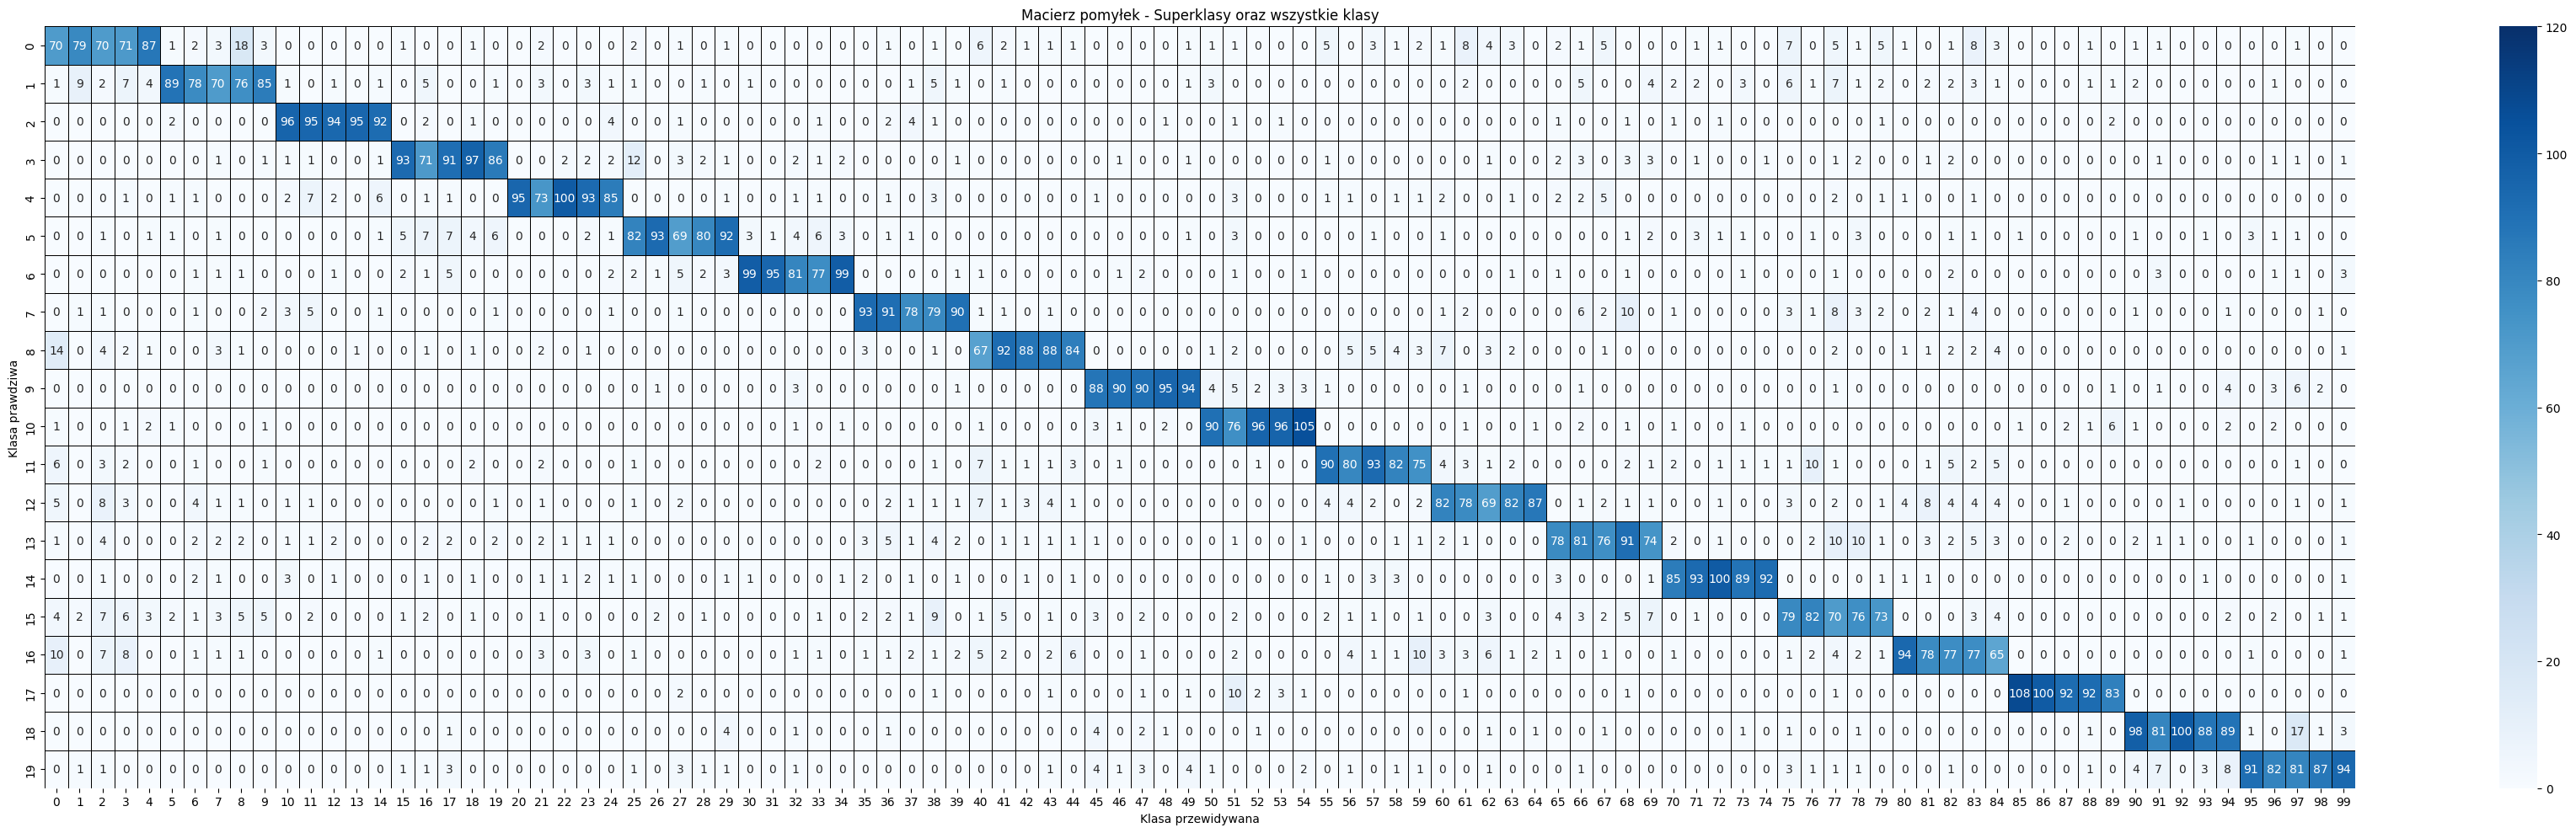

In [22]:
plt.figure(figsize=(35, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', linecolor='black',linewidths=0.5, xticklabels=np.arange(100), yticklabels=np.arange(20), vmin=0, vmax=120)
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa prawdziwa')
plt.title('Macierz pomyłek - Superklasy oraz wszystkie klasy')
plt.tight_layout()
plt.savefig('macierz_pomyłek_A75double.png')
plt.show()

In [23]:
def find_mistake_details(conf_matrix):
    superclasses = 20
    normal_classes_per_superclass = 5
    result = []

    for superclass in range(superclasses):
        normal_class_indices = list(range(superclass * normal_classes_per_superclass,(superclass + 1) * normal_classes_per_superclass))
        row = conf_matrix[superclass, :]

        sum_superclass_examples = row[normal_class_indices].sum()
        
        masked_row = np.ma.masked_array(row, mask=False)
        masked_row.mask[normal_class_indices] = True

        max_mistake_class_1 = masked_row.argmax()
        max_mistake_count_1 = masked_row[max_mistake_class_1]
        
        masked_row.mask[max_mistake_class_1] = True
        
        max_mistake_class_2 = masked_row.argmax()
        max_mistake_count_2 = masked_row[max_mistake_class_2]
        
        result.append([superclass, sum_superclass_examples, max_mistake_class_1, max_mistake_count_1, max_mistake_class_2, max_mistake_count_2])
    return result


mistake_details = find_mistake_details(conf_matrix)

# DataFrame
columns = ['superclass_index', 'sum_superclass_examples', 'max_mistake_class_1', 'max_mistake_count_1', 'max_mistake_class_2', 'max_mistake_count_2']
df = pd.DataFrame(mistake_details, columns=columns)

print(df)
df.head()

    superclass_index  sum_superclass_examples  max_mistake_class_1  \
0                  0                      377                    8   
1                  1                      398                    1   
2                  2                      472                   24   
3                  3                      438                   25   
4                  4                      446                   11   
5                  5                      416                   16   
6                  6                      451                   17   
7                  7                      431                   68   
8                  8                      419                    0   
9                  9                      457                   97   
10                10                      463                   89   
11                11                      420                   76   
12                12                      398                    2   
13                13

,superclass_index,sum_superclass_examples,max_mistake_class_1,max_mistake_count_1,max_mistake_class_2,max_mistake_count_2
0,0,377,8,18,61,8
1,1,398,1,9,3,7
2,2,472,24,4,37,4
3,3,438,25,12,27,3
4,4,446,11,7,14,6


In [ ]:
df.to_csv('mistake_details_cifar_100aftertrl.csv', index=False)

In [24]:
def find_mistake_details(conf_matrix):
    superclasses = 20
    normal_classes_per_superclass = 5
    result = []

    for superclass in range(superclasses):
        normal_class_indices = list(range(superclass * normal_classes_per_superclass,(superclass + 1) * normal_classes_per_superclass))
        row = conf_matrix[superclass, :]

        sum_superclass_examples = row[normal_class_indices].sum()
        
        masked_row = np.ma.masked_array(row, mask=False)
        masked_row.mask[normal_class_indices] = True
        
        max_mistake_class_1 = masked_row.argmax()
        max_mistake_count_1 = masked_row[max_mistake_class_1]
         
        masked_row.mask[max_mistake_class_1] = True
        
        max_mistake_class_2 = masked_row.argmax()
        max_mistake_count_2 = masked_row[max_mistake_class_2]
        
        result.append([superclass,train_data_20.coarse_label_names[superclass], sum_superclass_examples, max_mistake_class_1,fine_to_new_index_names[max_mistake_class_1], max_mistake_count_1, max_mistake_class_2,fine_to_new_index_names[max_mistake_class_2], max_mistake_count_2])
    
    return result

mistake_details = find_mistake_details(conf_matrix)

columns = ['superclass_index','superclass_name', 'sum_superclass_examples', 'max_mistake_class_1','max_class_1_name', 'max_mistake_count_1', 'max_mistake_class_2','max_class_2_name', 'max_mistake_count_2']
df = pd.DataFrame(mistake_details, columns=columns)


print(df)
df.head()

    superclass_index                 superclass_name  sum_superclass_examples  \
0                  0                 aquatic mammals                      377   
1                  1                            fish                      398   
2                  2                         flowers                      472   
3                  3                 food containers                      438   
4                  4            fruit and vegetables                      446   
5                  5    household electrical devices                      416   
6                  6             household furniture                      451   
7                  7                         insects                      431   
8                  8                large carnivores                      419   
9                  9   large man-made outdoor things                      457   
10                10    large natural outdoor scenes                      463   
11                11  large 

,superclass_index,superclass_name,sum_superclass_examples,max_mistake_class_1,max_class_1_name,max_mistake_count_1,max_mistake_class_2,max_class_2_name,max_mistake_count_2
0,0,aquatic mammals,377,8,shark,18,61,porcupine,8
1,1,fish,398,1,dolphin,9,3,seal,7
2,2,flowers,472,24,sweet_pepper,4,37,butterfly,4
3,3,food containers,438,25,clock,12,27,lamp,3
4,4,fruit and vegetables,446,11,poppy,7,14,tulip,6


In [26]:
df.to_csv('mistake_details_cifar_100A75.csv', index=False)